# 1. Introduction

## Cardiovascular Disease Risk Prediction

This project uses a cardiovascular dataset of 70,000 patients to explore risk factors and build a predictive model for cardiovascular disease (CVD).

**Goals:**
- Clean and preprocess the dataset.
- Explore relationships between BMI, blood pressure, cholesterol, glucose, and CVD.
- Engineer medically meaningful features (e.g. BMI categories, blood pressure stages).
- Train a classification model to predict CVD.

**Tools:** Python (Pandas, NumPy, Matplotlib, Seaborn, Scikit-learn)


# 2. Imports and Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rcParams
from scipy.stats import mannwhitneyu
from scipy.stats import chi2_contingency
import statsmodels

In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

In [3]:
from utils.plotting import plot_hist, plot_bar, barh_percent,plot_cvd_stacked_bar, plot_stacked_counts, plot_heatmap_table, plot_categorical_distribution,plot_categorical_subplot
from utils.evaluation import train_binary_classifier
from utils.categorize import categorize_bp

In [4]:
import config

In [5]:
config.DATASET_NAME.parent / "train.csv"

PosixPath('/Users/lizarabkina/PythonProjects/Cardio/data/train.csv')

In [6]:
df = pd.read_csv(config.DATASET_NAME, sep=";")

In [7]:
original_df = df.copy()
original_df.shape

(70000, 13)

In [8]:
df = original_df.copy() # working dataframe


# 3. Dataset Overview


### 3.1 Dataset Description

In [9]:
df.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


In [10]:
df.shape,df.columns
print(f"There are total of {df.shape[0]} datapoints in this dataset with {(df.shape[1])} columns:")
print(", ".join(df.columns))

There are total of 70000 datapoints in this dataset with 13 columns:
id, age, gender, height, weight, ap_hi, ap_lo, cholesterol, gluc, smoke, alco, active, cardio


### 3.2 Feature Description



| Feature        | Description |
|----------------|-------------|
| **age**        | Age of the patient in days *(convert to years)* |
| **gender**     | 1 = female, 2 = male |
| **height**     | Height in centimeters |
| **weight**     | Weight in kilograms |
| **ap_hi**      | Systolic blood pressure |
| **ap_lo**      | Diastolic blood pressure |
| **cholesterol**| 1 = normal, 2 = above normal, 3 = well above normal |
| **gluc**       | 1 = normal, 2 = above normal, 3 = well above normal |
| **smoke**      | Binary lifestyle feature (0 = no, 1 = yes) |
| **alco**       | Binary lifestyle feature (0 = no, 1 = yes) |
| **active**     | Physical activity (0 = no, 1 = yes) |
| **cardio**     | **Target:** Cardiovascular disease (1 = yes, 0 = no) |


### 3.3 Checking datatypes

In [11]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           70000 non-null  int64  
 1   age          70000 non-null  int64  
 2   gender       70000 non-null  int64  
 3   height       70000 non-null  int64  
 4   weight       70000 non-null  float64
 5   ap_hi        70000 non-null  int64  
 6   ap_lo        70000 non-null  int64  
 7   cholesterol  70000 non-null  int64  
 8   gluc         70000 non-null  int64  
 9   smoke        70000 non-null  int64  
 10  alco         70000 non-null  int64  
 11  active       70000 non-null  int64  
 12  cardio       70000 non-null  int64  
dtypes: float64(1), int64(12)
memory usage: 6.9 MB


### 3.4 Basic Statistics

In [12]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
id,70000.0,49972.419900,28851.302323,0.0,25006.75,50001.5,74889.25,99999.0
age,70000.0,19468.865814,2467.251667,10798.0,17664.00,19703.0,21327.00,23713.0
gender,70000.0,1.349571,0.476838,1.0,1.00,1.0,2.00,2.0
height,70000.0,164.359229,8.210126,55.0,159.00,165.0,170.00,250.0
weight,70000.0,74.205690,14.395757,10.0,65.00,72.0,82.00,200.0
ap_hi,70000.0,128.817286,154.011419,-150.0,120.00,120.0,140.00,16020.0
ap_lo,70000.0,96.630414,188.472530,-70.0,80.00,80.0,90.00,11000.0
cholesterol,70000.0,1.366871,0.680250,1.0,1.00,1.0,2.00,3.0
gluc,70000.0,1.226457,0.572270,1.0,1.00,1.0,1.00,3.0
smoke,70000.0,0.088129,0.283484,0.0,0.00,0.0,0.00,1.0


### 3.5 Handle missing values
In this step, I check for missing values and decide how to treat them.

In [13]:
print("Missing values:\n",df.isnull().sum())

Missing values:
 id             0
age            0
gender         0
height         0
weight         0
ap_hi          0
ap_lo          0
cholesterol    0
gluc           0
smoke          0
alco           0
active         0
cardio         0
dtype: int64


- No missing values are observed, therefore we continue to the next step of analysis.

### 3.6 Columns removal

In this section I removed "id" column since it didn't bring any value for the analysis

In [14]:
df = df.drop(columns=['id'])

### 3.7 Handling duplicates

In [15]:
print(f"Dataset contains {df.duplicated().sum()} duplicates.")

Dataset contains 24 duplicates.


In this step I will remove duplicates

In [16]:
duplicated = df[df.duplicated(keep=False)]
duplicated = duplicated.sort_values(by=['gender', 'height', 'weight'], ascending= False)
duplicated.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
10494,16937,2,170,70.0,120,80,1,1,0,0,0,0
44653,16937,2,170,70.0,120,80,1,1,0,0,0,0
1142,17493,2,169,74.0,120,80,1,1,0,0,1,1
50432,17493,2,169,74.0,120,80,1,1,0,0,1,1
32683,17535,2,165,65.0,120,80,1,1,0,0,1,0


In [17]:
df.drop_duplicates(keep="first", inplace =True)
print(f"After removal of duplicates total of {df.shape[0]} rows and {df.shape[1]} columns remained.")

After removal of duplicates total of 69976 rows and 12 columns remained.


### 3.8 Target balance

In [18]:
print("Target groups (absolute values):",df["cardio"].value_counts())
print("_______________________________")
print("Target groups (%):",df["cardio"].value_counts(normalize=True).mul(100).round(2).astype(str) + "%")

Target groups (absolute values): cardio
0    35004
1    34972
Name: count, dtype: int64
_______________________________
Target groups (%): cardio
0    50.02%
1    49.98%
Name: proportion, dtype: object


- The dataset is equally balanced

# 4. Data cleaning


In this section I clean the raw dataset by:

- converting age from days to years
- handling unrealistic height, weight, and blood pressure values
- removing outliers
- preparing a clean DataFrame (df_clean) for further analysis


In [19]:
df_clean = df.copy()

### 4.1 Convert age and create BMI

In [20]:
# 1. Convert age in days to years
df_clean["age_years"]= df_clean["age"] / 365.25
# 2. Calculate BMI
df_clean["bmi"] = (df_clean["weight"] / (df_clean["height"]/100)**2).round(1)



### 4.2 Outliers exploratory analysis 

In [21]:
num_cols = df_clean.select_dtypes(include=np.number).columns

summary_table_ = df_clean[num_cols].agg(['min', 'max']).T.round(0)
summary_table_

,min,max
age,10798.0,23713.0
gender,1.0,2.0
height,55.0,250.0
weight,10.0,200.0
ap_hi,-150.0,16020.0
ap_lo,-70.0,11000.0
cholesterol,1.0,3.0
gluc,1.0,3.0
smoke,0.0,1.0
alco,0.0,1.0


- Height: remove unrealistic height (the lowest 55 cm) 
- Weight: remove unrealistic weight (the lowest 10 kg)
- ap_hi,ap_lo: can't be negative and a big number


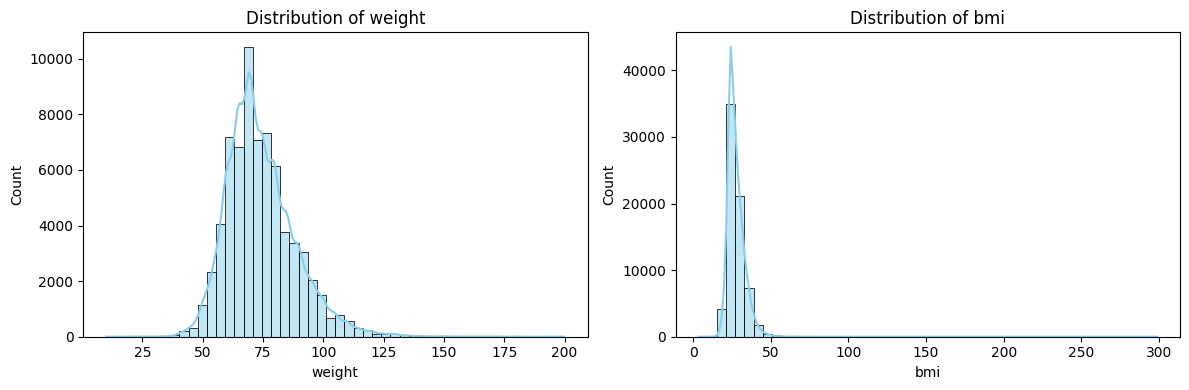

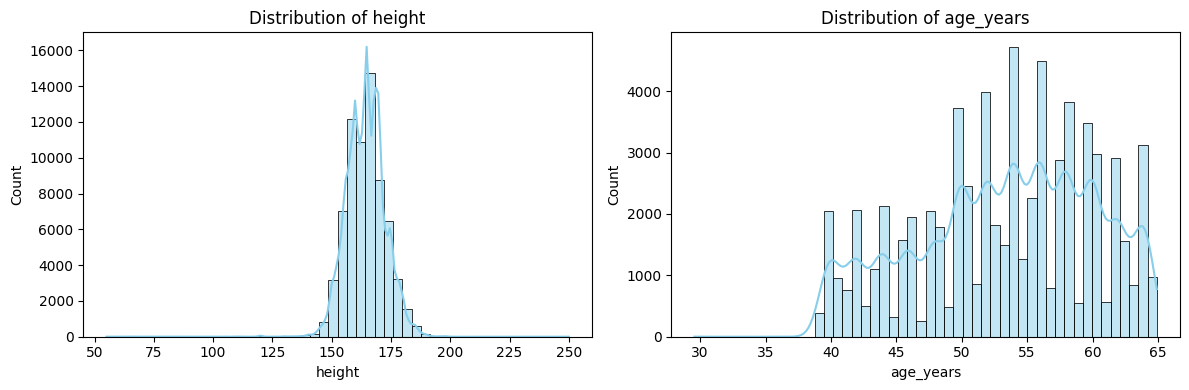

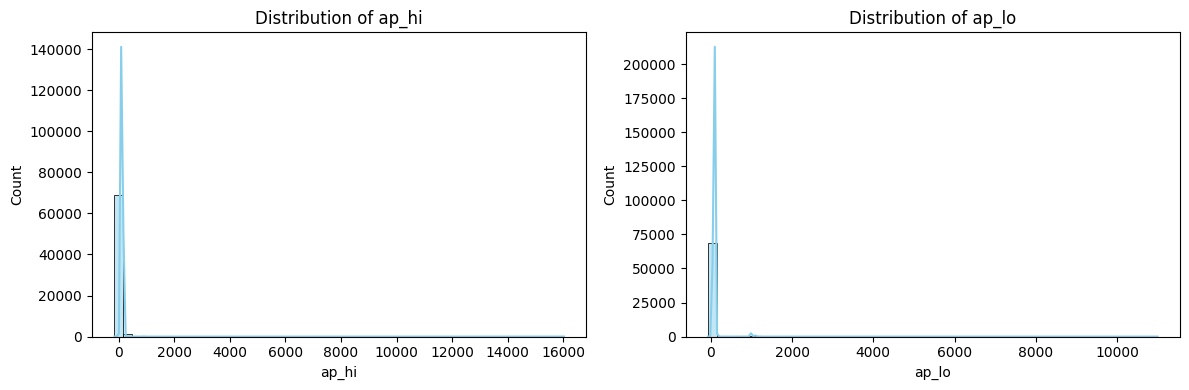

In [22]:
bmi_weight_before = plot_hist(df_clean,["weight","bmi"])
height_age_before = plot_hist(df_clean,["height","age_years"])
ap_hi_lo_before = plot_hist(df,["ap_hi","ap_lo"])

BMI Cut off

In [23]:
# remove BMI <12
pd.set_option('display.max_rows', None)
df_clean[df_clean["bmi"]<12].sort_values(by = "bmi",ascending=False).head()


,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,age_years,bmi
18559,18140,1,160,30.0,120,80,1,1,0,0,1,1,49.664613,11.7
16906,17272,2,170,31.0,150,90,2,2,0,0,1,1,47.288159,10.7
60699,18875,1,171,29.0,110,70,2,1,0,0,1,1,51.676934,9.9
26806,23284,1,157,23.0,110,80,1,1,0,0,1,0,63.748118,9.3
60188,21855,1,162,21.0,120,80,2,1,0,0,1,1,59.835729,8.0


In [24]:
# remove BMI>60
df_clean[df_clean["bmi"]>60].sort_values(by = "bmi",ascending=False).head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,age_years,bmi
12770,19594,1,75,168.0,120,80,1,1,1,0,1,1,53.645448,298.7
27384,15292,1,80,178.0,140,90,3,3,0,0,1,1,41.867214,278.1
22723,23386,1,55,81.0,130,90,1,1,0,0,1,1,64.027379,267.8
23913,19074,1,81,156.0,140,90,1,1,0,0,1,0,52.221766,237.8
29157,19088,1,60,69.0,110,70,1,1,0,0,0,0,52.260096,191.7


Height and Age cut off

In [25]:
# remove height <140cm
df_clean[df_clean["height"]<140].sort_values(by = "bmi",ascending=False).head()


,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,age_years,bmi
12770,19594,1,75,168.0,120,80,1,1,1,0,1,1,53.645448,298.7
27384,15292,1,80,178.0,140,90,3,3,0,0,1,1,41.867214,278.1
22723,23386,1,55,81.0,130,90,1,1,0,0,1,1,64.027379,267.8
23913,19074,1,81,156.0,140,90,1,1,0,0,1,0,52.221766,237.8
29157,19088,1,60,69.0,110,70,1,1,0,0,0,0,52.260096,191.7


Blood pressure values (ap_hi/ap_lo) cut off

In [26]:
df_clean["ap_hi"] = df_clean["ap_hi"].astype(float)
df_clean["ap_lo"] = df_clean["ap_lo"].astype(float)

# Fix extreme types like 1000,1401,etc
df_clean.loc[df_clean["ap_hi"] > 250, "ap_hi"] /= 10
df_clean.loc[df_clean["ap_lo"] > 200, "ap_lo"] /= 10

#Fix reversed values (if diastolic > systolic)
swap_mask = df_clean["ap_lo"] > df_clean["ap_hi"]
df_clean.loc[swap_mask, ["ap_hi", "ap_lo"]] = \
    df_clean.loc[swap_mask, ["ap_lo", "ap_hi"]].to_numpy()



### 4.3 Outliers removal


In [27]:
# Everything is " True"
mask = pd.Series(True, index=df_clean.index)

# 1. Height & BMI filters 
if "height" in df_clean.columns:
    mask &= df_clean["height"].between(140, 200)

if "bmi" in df_clean.columns:
    mask &= df_clean["bmi"].between(12, 60)

# 2. Age filter 
if "age_years" in df_clean.columns:
    mask &= df_clean["age_years"].between(18, 90)

# 3. Blood pressure filters
mask &= df_clean["ap_hi"].between(80, 250)
mask &= df_clean["ap_lo"].between(40, 150)
mask &= df_clean["ap_hi"] >= df_clean["ap_lo"] + 5
mask &= df_clean["ap_hi"] > 0
mask &= df_clean["ap_lo"] > 0

# 4. Weight filters
if "weight" in df_clean.columns:
    mask &= df_clean["weight"].between(40, 200)

# 4. Apply all filters at once
df_clean = df_clean[mask].copy()

df_clean["ap_hi"] = df_clean["ap_hi"].round().astype("Int64")
df_clean["ap_lo"] = df_clean["ap_lo"].round().astype("Int64")


In [28]:
num_cols = df_clean.select_dtypes(include=np.number).columns

summary_table_2 = df_clean[num_cols].agg(['min', 'max']).T.round(0)
summary_table_2

,min,max
age,10798.0,23713.0
gender,1.0,2.0
height,140.0,200.0
weight,40.0,200.0
ap_hi,80.0,240.0
ap_lo,40.0,150.0
cholesterol,1.0,3.0
gluc,1.0,3.0
smoke,0.0,1.0
alco,0.0,1.0


### 4.4 Number of datapoints after cleaning

In [29]:
print(f"Rows before cleaning: {len(original_df)}")
print(f"Rows after filtering: {len(df_clean)}")
print(f"Removed rows: {len(original_df) - len(df_clean)}")

Rows before cleaning: 70000
Rows after filtering: 69471
Removed rows: 529


I applied filters on height, BMI, age, blood pressure and weight.

In total I removed 529 rows  mostly due to huge blood pressure values, with a smaller number removed due to unrealistic measures.

Explanation of filters:(inclusion criteria)

- Height 140–200 cm & BMI 12–60 & Weight 40-200 kg 

- BP: physiology-(ap_hi 80–250, ap_lo 40–150, systolic > diastolic)

- Age 18–90: adults


# 5. Exploratory Data Analysis (EDA)

In this section I explore the distribution of key variables after cleaning and how they relate to cardiovascular disease (CVD).

### 5.1 Univariate Distribution


I first look at the distribution of age, BMI, and blood pressure after cleaning.

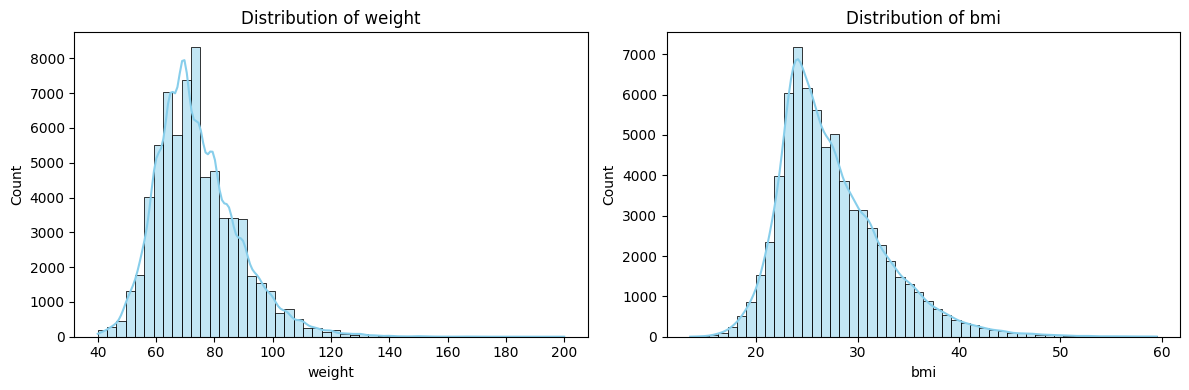

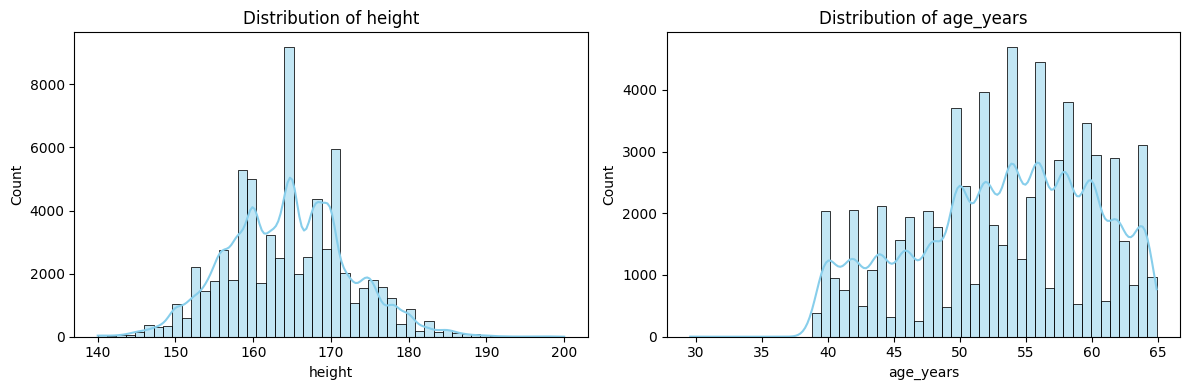

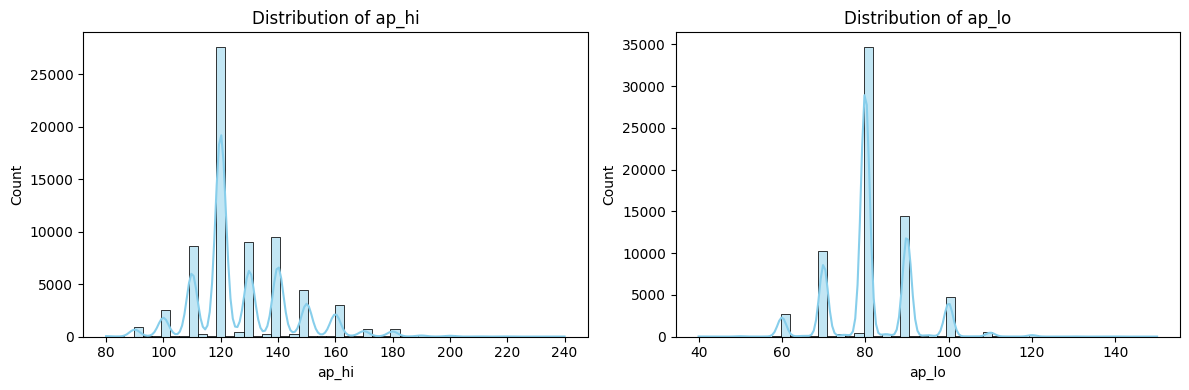

In [30]:
plot_hist(df_clean,["weight","bmi"])
plot_hist(df_clean,["height","age_years"])
plot_hist(df_clean,["ap_hi","ap_lo"])

### 5.2 Distribution of Numeric Features by Cardio Status

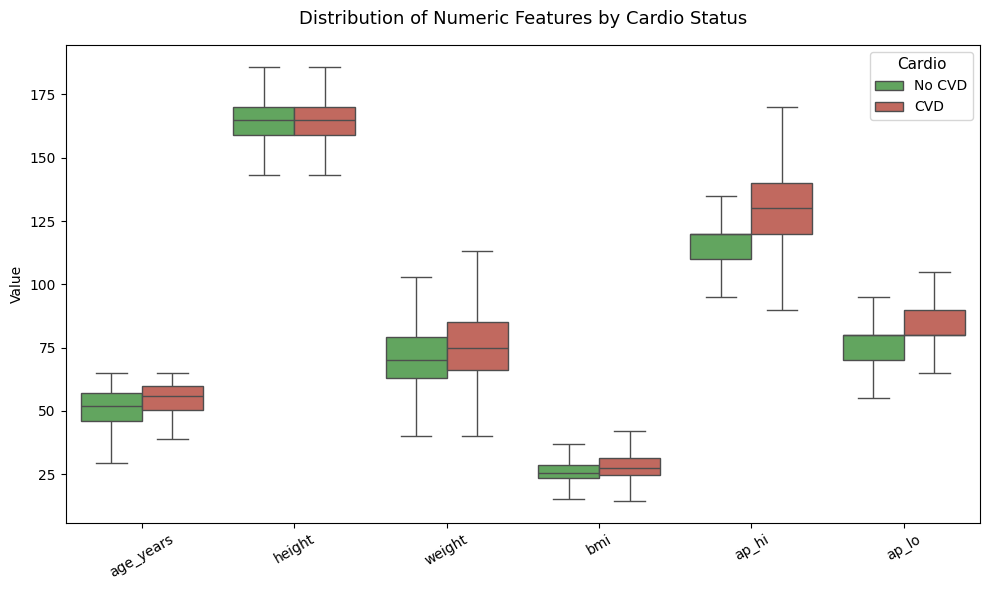

In [31]:
#  Melt the dataset into long format
df_melted = df_clean.melt(
    id_vars='cardio',
    value_vars=config.NUM_VARS,
    var_name='Feature',
    value_name='Value'
)


df_melted['cardio'] = df_melted['cardio'].map({0: 'No CVD', 1: 'CVD'})

# Create the boxplot
plt.figure(figsize=(10,6))
sns.boxplot(
    x='Feature',
    y='Value',
    hue='cardio',
    data=df_melted,
    palette={'No CVD': "#58B153", 'CVD': "#D15C4F"},
    showfliers=False
)

#  Style the plot
plt.title('Distribution of Numeric Features by Cardio Status', fontsize=13, pad=15)
plt.xlabel('')
plt.ylabel('Value')
plt.xticks(rotation=30)
plt.legend(title='Cardio', title_fontsize=11, fontsize=10)
plt.tight_layout()
plt.show()


##### Interpretation
CVD cases show higher age, BMI, weight, and especially blood pressure. Height does not differ between groups.

### 5.3 Distribution by gender

In order to confirm that females and males are labeled correctly in the dataset I computed average heights per gender

In [32]:
df_clean.groupby("gender")["height"].mean().round(2)

gender
1    161.46
2    170.06
Name: height, dtype: float64

We can confirm that Females (162cm) labeled as 1 and Males (170cm) labeled as 2.

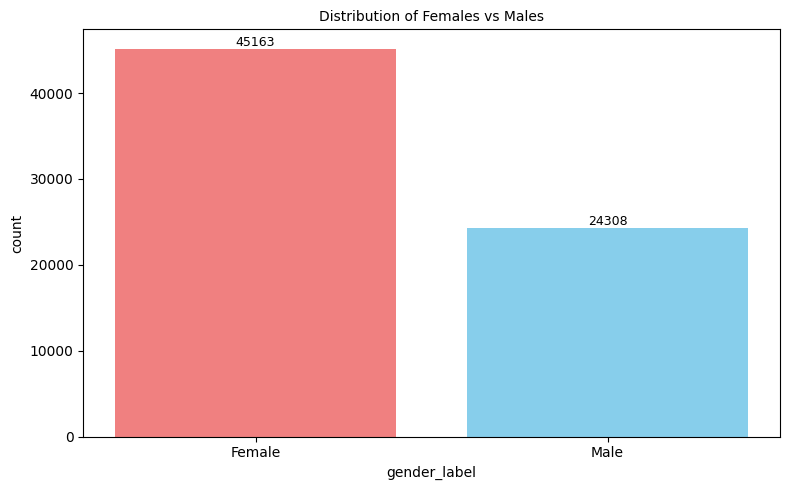

In [33]:
# Mapping gender values (1,2) to Male and Female
df_clean["gender_label"] = df["gender"].replace({1: "Female", 2: "Male"})
# Compute counts of individuals per gender
gender_counts = df_clean["gender_label"].value_counts().rename_axis("gender_label").reset_index(name="count")
# Plot
plot_bar(gender_counts,"gender_label","count",title ="Distribution of Females vs Males", color =["lightcoral","skyblue"])

#### Interpretation
**Note:** In the original dataset, gender is coded as: 1 = Female, 2 = Male. I mapped these values to labels for analysis.

In this dataset : Females - 63-64% and Males - 36-37 %

### 5.4 BMI category



I defined BMI bins using WHO standards:

- Underweight: < 18.5  
- Normal: 18.5–24.9  
- Overweight: 25–29.9  
- Obesity I: 30–34.9  
- Obesity II: 35–39.9  
- Obesity III: ≥ 40  



In [34]:
df_clean["bmi_bin"] = pd.cut(
    df_clean["bmi"],
    bins=config.BMI_BINS,
    labels=config.BMI_LABELS,
    right=False,           
    include_lowest=True
).astype("category").cat.set_categories(config.BMI_LABELS, ordered=True)


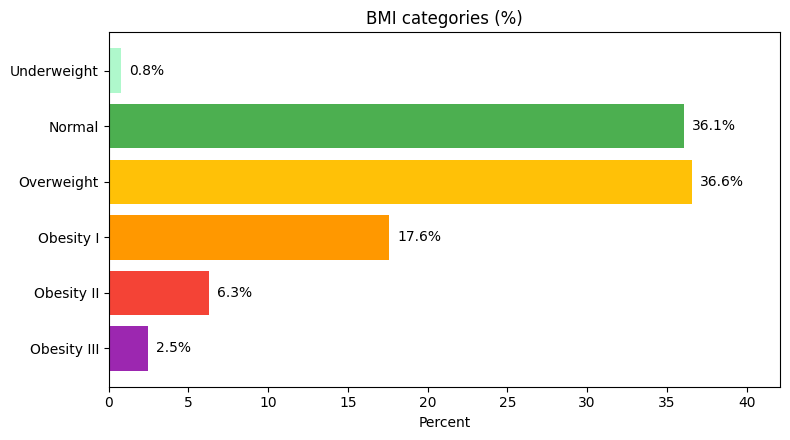

In [35]:
# Define bmi order and bmi colors for further analysis
bmi_counts = (
    df_clean["bmi_bin"]
    .value_counts()
    .rename_axis("bmi_bin")
    .reset_index(name="count")
    .sort_values("bmi_bin")
)

# plot
barh_percent(
    df_clean,
    "bmi_bin",
    order=config.BMI_LABELS[::-1],
    title="BMI categories (%)",
    palette=config.GRADIENT_COLORS[::-1],
)

#### Interpretation 
- 36.1% of individuals fall in the normal BMI range.

- 36.6% are overweight, the largest group in the dataset.

- 27.3% are in the obesity categories (I, II, III).

- Only 0.8% are underweight.

Overall, about 64% of the population has excess body weight, showing that this sample aligns more with a higher-risk clinical population

### 5.5 Blood pressure category

#### 5.5.1 Distribution of BP

In [36]:
# create bp categories
df_clean["bp_category"]=df_clean.apply(categorize_bp,axis=1)

bp_counts = (
    df_clean["bp_category"]
    .value_counts()
    .rename_axis("bp_category")
    .reset_index(name="count")
)



In [37]:
# make bp_category -> categorical variable
df_clean["bp_category"] = pd.Categorical(
    df_clean["bp_category"],
    categories=config.BP_ORDER,
    ordered=True
)

In [38]:
bp_counts.head()

,bp_category,count
0,Hypertension Stage 1,39764
1,Hypertension Stage 2,16929
2,Normal,9520
3,Elevated,3098
4,Hypertensive Crisis,160


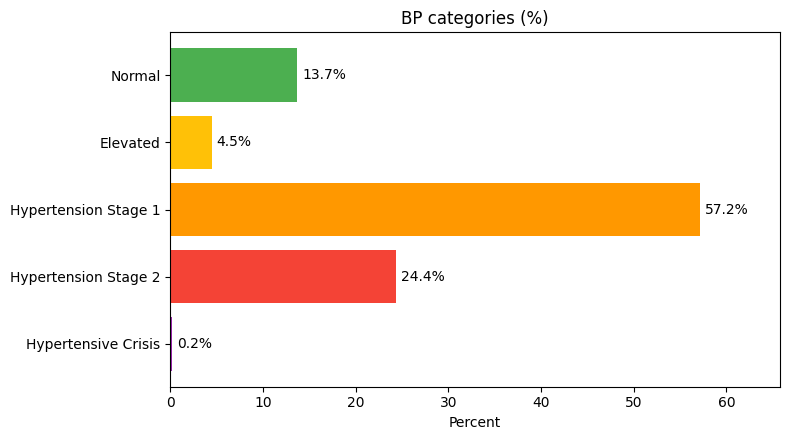

In [39]:
barh_percent(
    df_clean,
    "bp_category",
    order=config.BP_ORDER[::-1],
    title="BP categories (%)",
    palette=config.GRADIENT_COLORS[::-1]
)

#### Interpretation

- 13.7% of individuals have normal blood pressure.

- 4.5% fall into the elevated category.

- 57.2% are classified as Hypertension Stage 1.

- 24.4% fall into Hypertension Stage 2.

- Only 0.23% are in Hypertensive Crisis, which is severe but rare.

Overall, about 82% of the population is hypertensive, indicating that this dataset reflects a higher-risk clinical population rather than a general healthy sample.

#### 5.5.2 Distribution of BP per gender

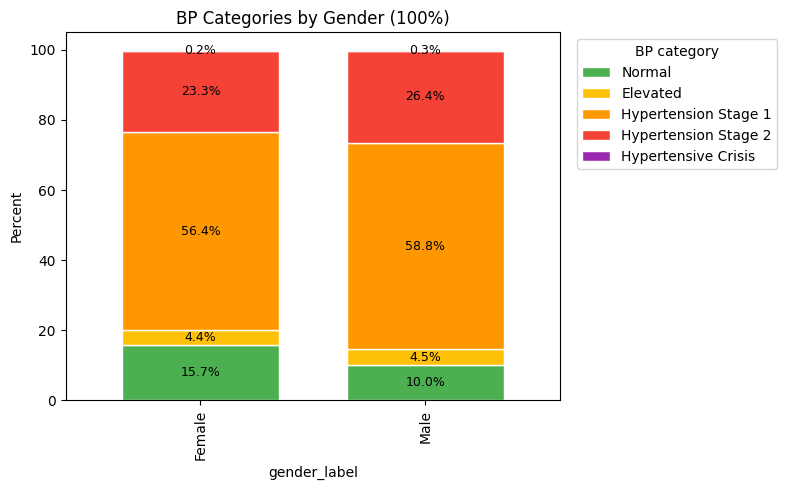

In [40]:
# Crosstab (percentage distribution of BP categories within each gender)
ct = pd.crosstab(
    df_clean["gender_label"],
    df_clean["bp_category"],
    normalize="index"
) * 100

# plot 
ax = ct.plot(kind="bar", stacked=True, figsize=(8,5), color=config.GRADIENT_COLORS[1:], edgecolor="white", width=0.7)
for container in ax.containers:
    ax.bar_label(container, fmt="%.1f%%", label_type="center", fontsize=9, color="black")
plt.ylabel("Percent"); plt.title("BP Categories by Gender (100%)")
plt.legend(title="BP category", bbox_to_anchor=(1.02,1), loc="upper left")
plt.tight_layout(); plt.show()

#### Interpretation

- Females have a higher share of normal blood pressure (15.7%) than males (10%).

- Men show slightly higher rates of Hypertension Stage 1 and Stage 2.

Overall: Men in this dataset appear to have a higher prevalence of hypertension.


### 5.6 Cardio Vascular Disease (CVD) prevalence

#### 5.6.1 CVD prevalence by Blood Pressure

In [41]:
# Labeling individuls based on cardio status
df_clean["cardio_label"]=df_clean["cardio"].map({0:"No CVD",1:"CVD"})

In [42]:
# count of individula per each bp category
df_clean["bp_category"].value_counts().sort_index()

bp_category
Normal                   9520
Elevated                 3098
Hypertension Stage 1    39764
Hypertension Stage 2    16929
Hypertensive Crisis       160
Name: count, dtype: int64

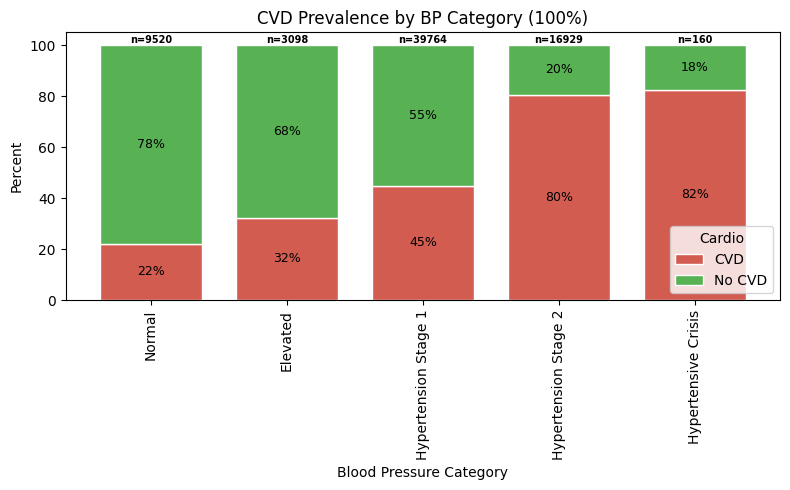

In [43]:
plot_cvd_stacked_bar(df_clean,"bp_category",title="CVD Prevalence by BP Category (100%)",xlabel="Blood Pressure Category")

##### Interpretation

- CVD prevalence rises steadily from 22% in normal BP to 45% in Stage 1.

- It becomes very high in Stage 2 (≈80%) and Hypertensive Crisis (≈82%).

Overall: Severe hypertension is strongly associated with a much higher likelihood of CVD.

#### 5.6.2 CVD prevalence by Age

In [44]:
# create age bins
df_clean["age_bin"] = pd.cut(df_clean["age_years"], bins=config.AGE_BINS, labels=config.AGE_NAMES, right=False)

In [45]:
# counts per age bin
df_clean["age_bin"].value_counts().sort_index()

age_bin
18-39     1864
40-49    19627
50-59    35302
60-89    12678
Name: count, dtype: int64

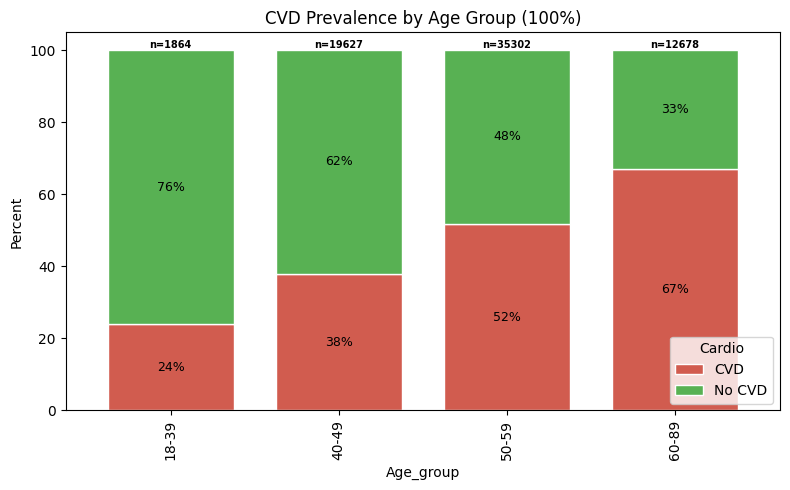

In [46]:
plot_cvd_stacked_bar(df_clean,"age_bin",title= "CVD Prevalence by Age Group (100%)", xlabel="Age_group")

##### Interpretation

CVD prevalence increases almost linearly with age.

- 18–39: ~24%

- 40–49: ~38%

- 50–59: ~52%

- 60–69: ~67%

Older groups show a much higher rate of CVD, which aligns with clinical expectations.

#### 5.6.3 CVD prevalence by BMI

In [47]:
df_clean["bmi_bin"].value_counts().sort_index()

bmi_bin
Underweight      577
Normal         25069
Overweight     25427
Obesity I      12242
Obesity II      4385
Obesity III     1771
Name: count, dtype: int64

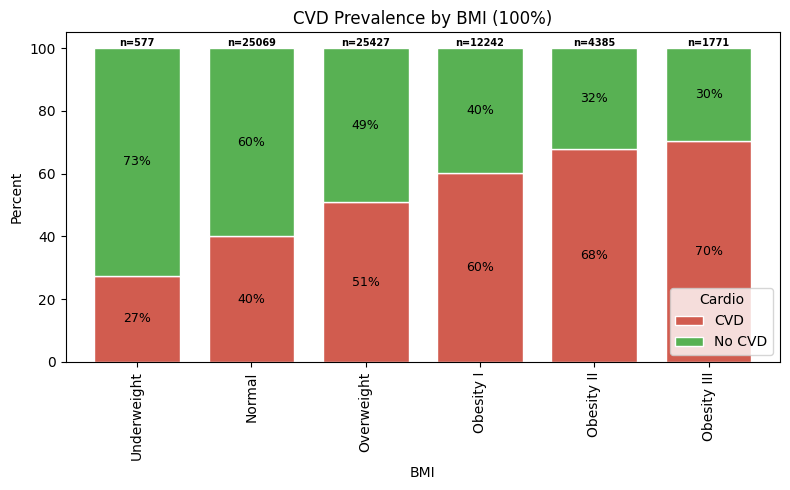

In [48]:
plot_cvd_stacked_bar(df_clean,"bmi_bin",title= "CVD Prevalence by BMI (100%)", xlabel="BMI")

##### Interpretation

- CVD rates are lowest in the underweight and normal BMI groups (about 27–40%).

- The overweight group already shows a higher risk (~51%).

- CVD prevalence rises sharply in the obesity categories, reaching 60–70%.

Overall: Higher BMI is strongly associated with an increased likelihood of cardiovascular disease.



### 5.7 Metabolic & Lifestyle Factors 

#### 5.7.1 Factor labeling

In [49]:
# Assingning labels to all factors
df_clean["cholesterol_label"]=df_clean["cholesterol"].map({1:"Normal", 2:"Above Normal", 3:"Well Above Normal"})
df_clean["glucose_label"]=df_clean["gluc"].map({1:"Normal", 2:"Above Normal", 3:"Well Above Normal"})
df_clean["smoke_label"]=df_clean["smoke"].map({0:"No", 1:"Yes"})
df_clean["alcohol_label"]=df_clean["alco"].map({0:"No", 1:"Yes"})
df_clean["active_label"]=df_clean["active"].map({0:"No", 1:"Yes"})


#### 5.7.2.Distribution of Metabolic Factors

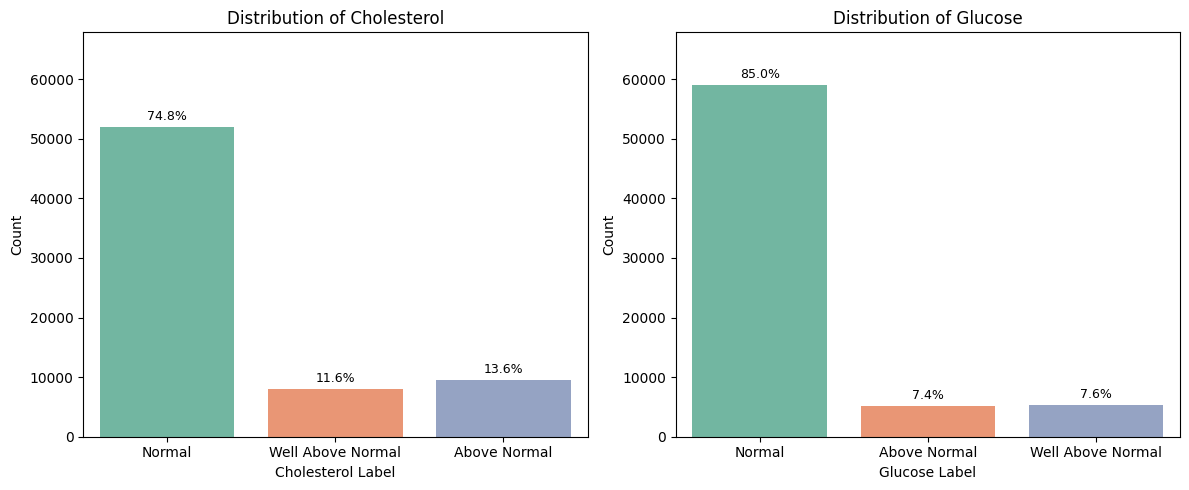

In [50]:
plot_categorical_subplot(df_clean,["cholesterol_label","glucose_label"])


#### 5.7.3.Distribution of Lifestyle Factors

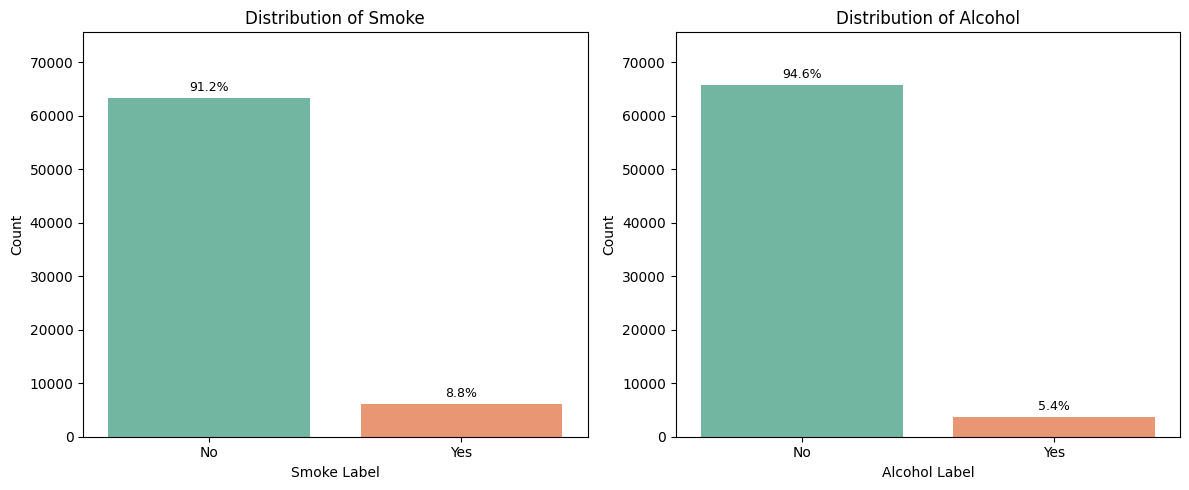

In [51]:
plot_categorical_subplot(df_clean,["smoke_label","alcohol_label"])

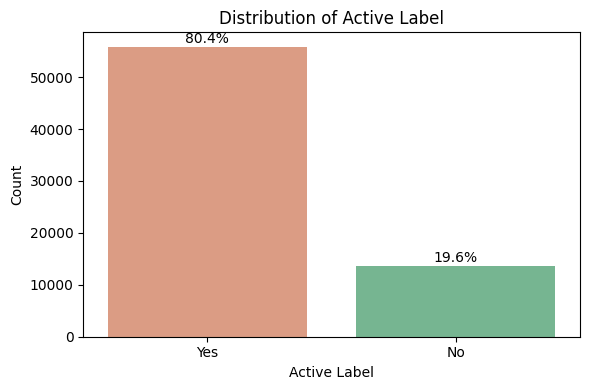

In [52]:
plot_categorical_distribution(df_clean,"active_label",palette = {
    "No": "#6BBF8F",   # green
    "Yes":  "#E99675" ,
})

##### Interpretation

- The lifestyle patterns in this dataset show that most people have normal cholesterol and normal glucose levels. 

- The majority also do not smoke and do not report regular alcohol use.

- Around 80% of individuals say they are physically active, while about 20% report that they do not exercise.

#### 5.7.4 Categorical Health Variables and CVD Trends

In [53]:
cat_health_var_labels = ["cholesterol_label", "glucose_label", "smoke_label", "alcohol_label", "active_label"]

In [54]:
var_order = {
    "cholesterol_label":config.STANDARD_BIO_INDICATOR_ORDER,
    "glucose_label": config.STANDARD_BIO_INDICATOR_ORDER,
    }

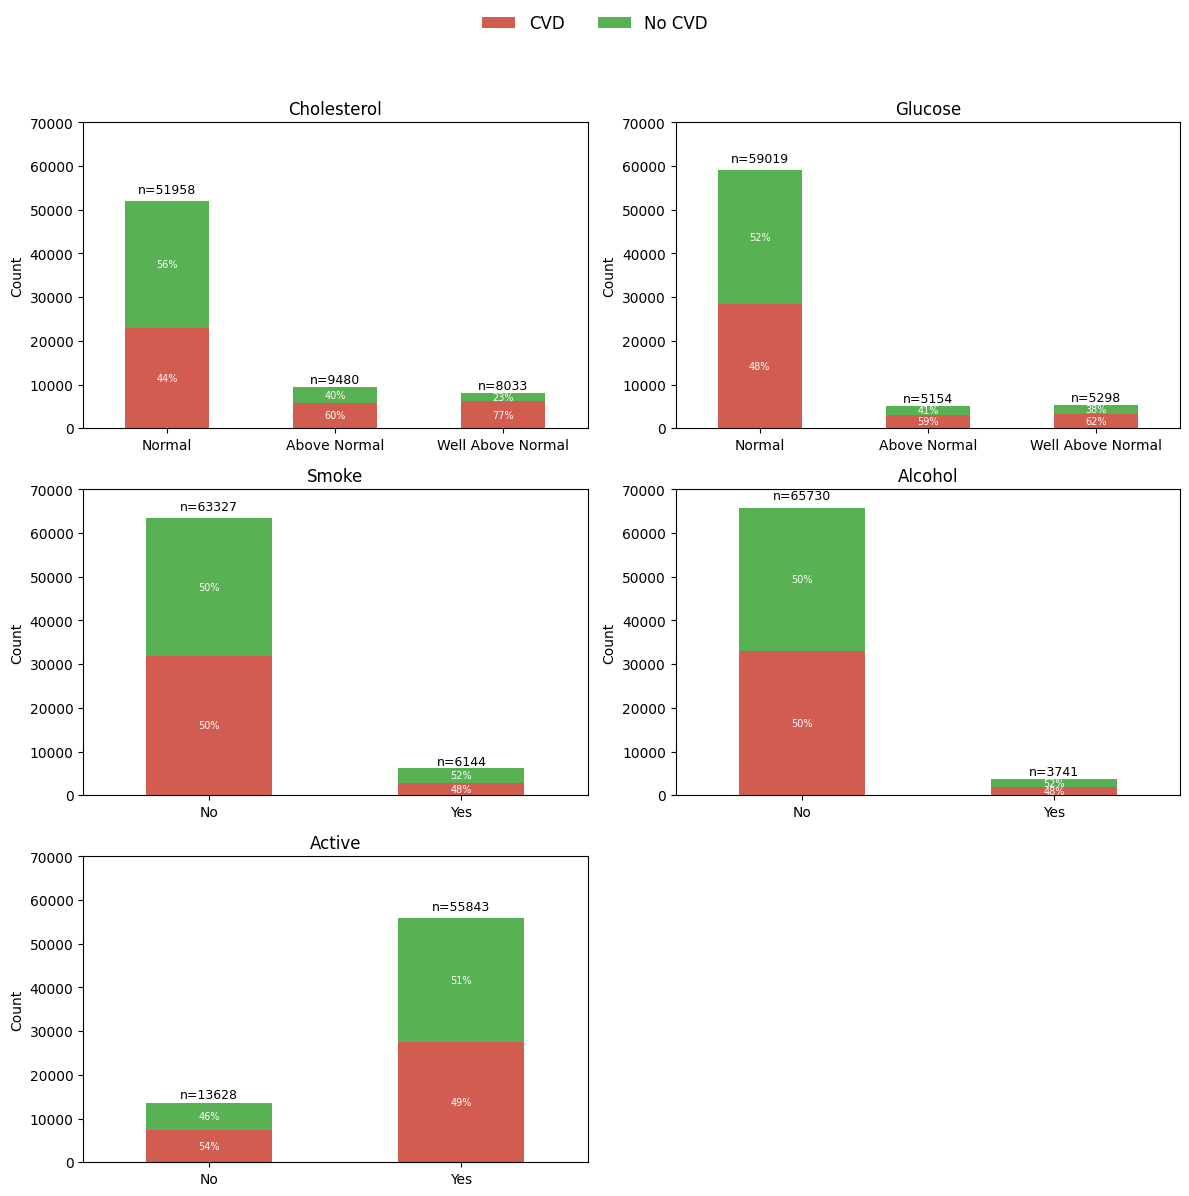

In [55]:
plot_stacked_counts(df_clean,
                    cat_health_var_labels,
                    "cardio_label",
                    var_order=var_order,
                    ncols=2,
                    colors =["#D15C4F","#58B153"],
                    rotation=0,
                    show_percent_inside=True,
                    show_totals_above=True,
                    legend_loc="upper center",
                    ymax =70000)

##### Interpretation

- Higher cholesterol and glucose levels are strongly associated with higher CVD rates.

- Smoking and alcohol use show almost no visible effect, likely because these groups are very small in the dataset.

- Physical inactivity shows a modest but noticeable increase in CVD prevalence.

Overall: Cholesterol, glucose, and physical activity appear useful for prediction, while smoking and alcohol should be interpreted cautiously due to imbalanced group sizes.

### 5.8 Correlation heatmap

In [56]:
# Remove categorical variables
df_clean_num = df_clean.drop(columns=["age", "gender","gender_label","bp_category","cardio_label","age_bin", "bmi_bin","cholesterol_label","glucose_label","smoke_label","alcohol_label","active_label"])
print(list(df_clean_num.columns))
# move cardio column at the bottom of a heatmap
cols = [col for col in df_clean_num.columns if col!= 'cardio'] + ['cardio']
df_clean_num = df_clean_num[cols]

['height', 'weight', 'ap_hi', 'ap_lo', 'cholesterol', 'gluc', 'smoke', 'alco', 'active', 'cardio', 'age_years', 'bmi']


- Spearman correlation is more appropriate for this dataset because it handles non-normal and monotonic clinical relationships better than Pearson.

<Axes: >

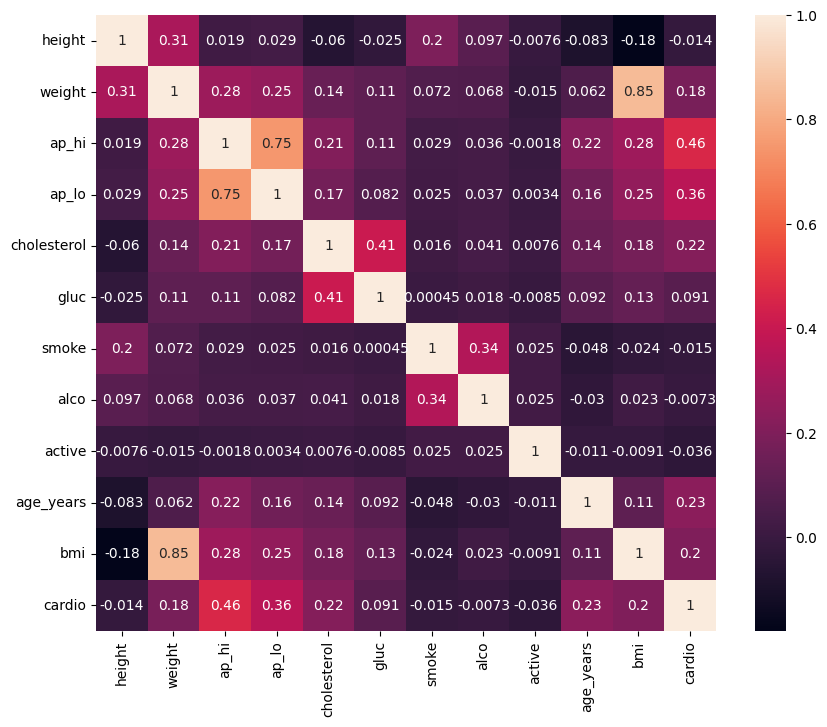

In [57]:
#Heatmap
plt.figure(figsize=(10, 8))
# Spearman correlation
sns.heatmap(df_clean_num.corr(method = "spearman"), annot=True)

#### Interpretation

From the last row/column (cardio) we see:
| **Feature**              | **Correlation With CVD** |
| ------------------------ | ------------------------ |
| **Systolic BP (ap_hi)**  | **0.46**                 |
| **Diastolic BP (ap_lo)** | **0.36**                 |
| **Age (age_years)**      | **0.23**                 |
| **Cholesterol**          | **0.22**                 |
| **BMI**                  | **0.20**                 |
| **Weight**               | **0.18**                 |


- Systolic and diastolic blood pressure show the strongest positive relationship with CVD status, followed by age and cholesterol levels. 

- BMI and weight also demonstrate moderate positive correlations. These variables, therefore, represent the most relevant predictors for modelling cardiovascular disease in this dataset.

### 5.9 High-Risk CVD Groups

#### 5.9.1 Ranking Table

In [58]:
# the group wih the highest risk for CVD among the dataset
risk_table = (
    df_clean
    .groupby(["gender_label", "bmi_bin", "bp_category"],observed=True)
    .agg(
        n=("cardio", "size"),
        cvd_rate=("cardio", "mean")
    )
)

risk_table["cvd_rate"] = (risk_table["cvd_rate"] * 100).round(1)

# keep only groups with enough people (> 50) to avoid tiny groups
risk_table = risk_table.query("n >= 50")
print(" Top 10 highest-risk groups")
risk_table.sort_values("cvd_rate", ascending=False).head(10)


 Top 10 highest-risk groups


n  cvd_rate
gender_label bmi_bin     bp_category                         
Male         Obesity II  Hypertension Stage 2   417      85.4
Female       Obesity III Hypertension Stage 2   681      84.4
             Obesity II  Hypertension Stage 2  1336      83.7
Male         Overweight  Hypertension Stage 2  2728      81.9
Female       Obesity I   Hypertension Stage 2  2737      81.2
Male         Obesity III Hypertension Stage 2   116      81.0
             Obesity I   Hypertension Stage 2  1443      80.9
Female       Overweight  Hypertension Stage 2  3490      79.7
Male         Normal      Hypertension Stage 2  1689      77.7
Female       Normal      Hypertension Stage 2  2232      77.2

#### 5.9.2 Heatmaps per gender

In [59]:
pd.crosstab(df_clean["gender_label"],
            df_clean["bp_category"])

bp_category,Normal,Elevated,Hypertension Stage 1,Hypertension Stage 2,Hypertensive Crisis
gender_label,,,,,
Female,7093,1993,25465,10513,99
Male,2427,1105,14299,6416,61


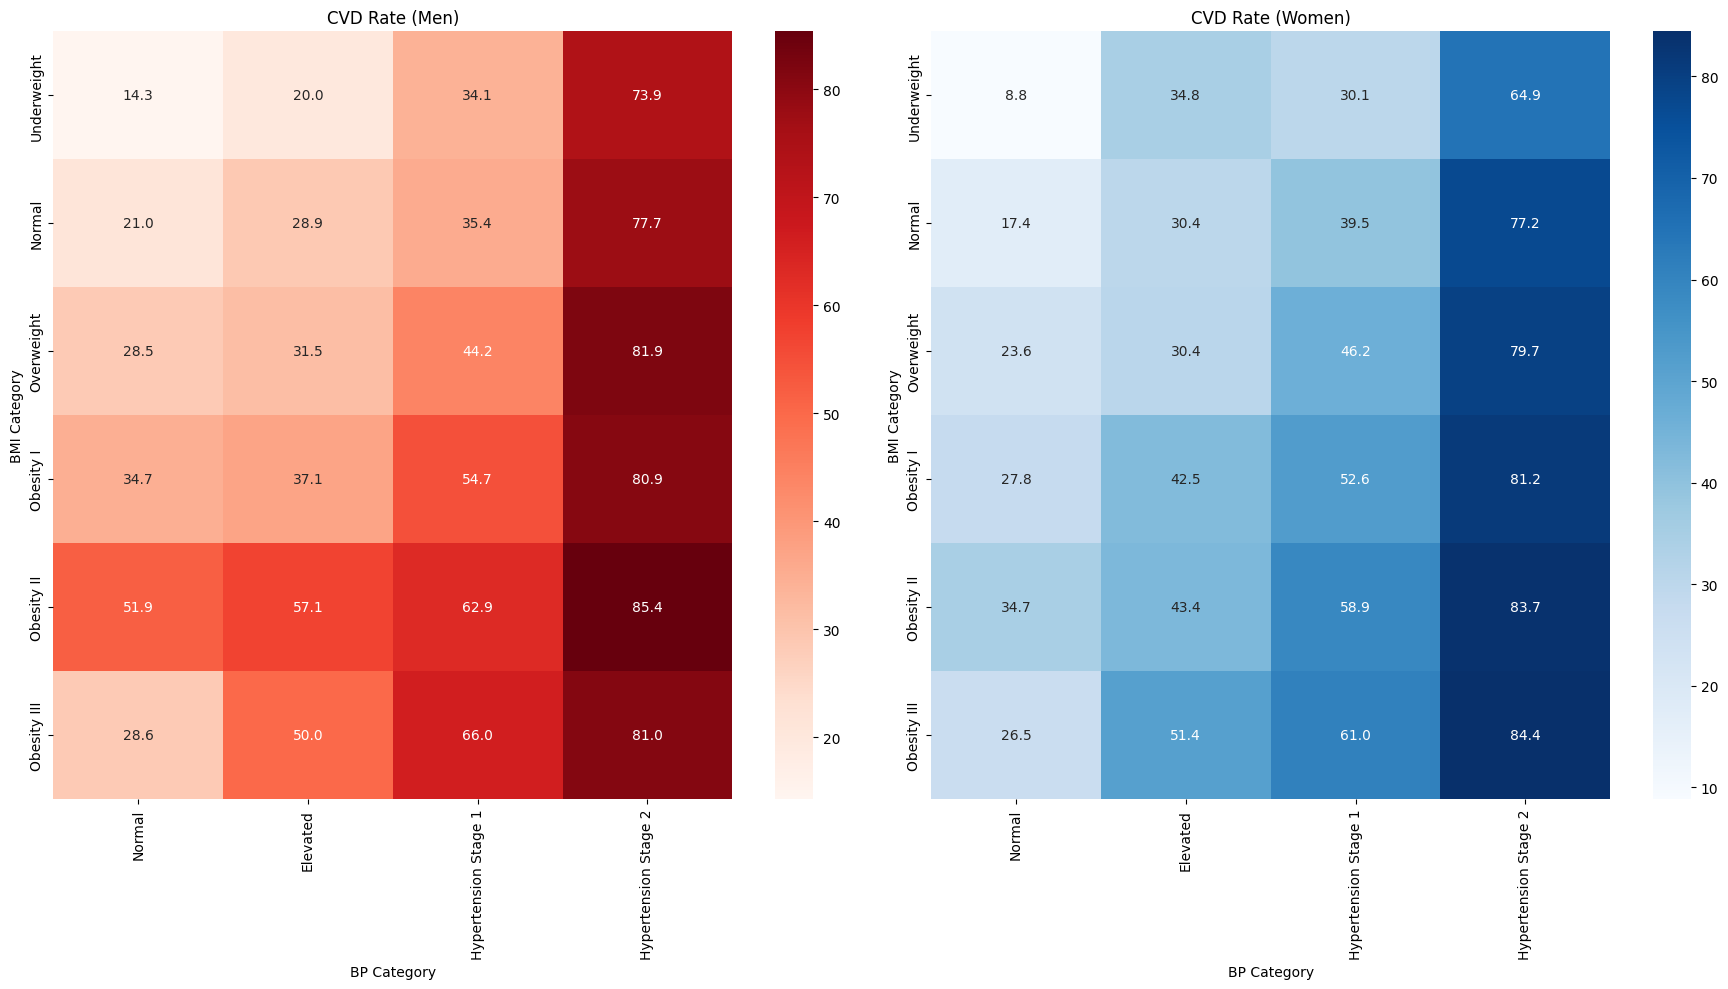

In [60]:
fig, axes = plt.subplots(1, 2, figsize=(18, 10))

df_clean_no_hc = df_clean[df_clean["bp_category"] != "Hypertensive Crisis"].copy()
df_clean_no_hc["bp_category"] = (
    df_clean_no_hc["bp_category"]
    .cat.remove_unused_categories()
)
# male
df_male = df_clean_no_hc[df_clean_no_hc["gender_label"] == "Male"]
male_heatmap = plot_heatmap_table(df_male, ["bmi_bin","bp_category"], "cardio",
              "CVD Rate (Men)", "BP Category", "BMI Category", axes[0], cmap="Reds")

# female
df_female = df_clean_no_hc[df_clean_no_hc["gender_label"] == "Female"]
female_heatmap = plot_heatmap_table(df_female, ["bmi_bin","bp_category"], "cardio",
              "CVD Rate (Women)", "BP Category", "BMI Category", axes[1], cmap="Blues")

plt.tight_layout()
plt.show()

<Axes: xlabel='bp_category', ylabel='bmi_bin'>

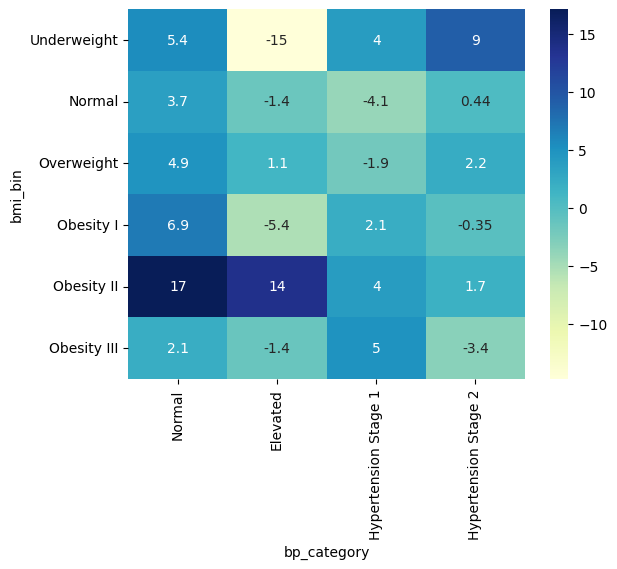

In [61]:
# Difference of CVD Rate between men and women
sns.heatmap(male_heatmap - female_heatmap, annot=True, cmap='YlGnBu')

#### Interprepation

- CVD prevalence increases sharply with both higher BMI and worse blood-pressure stage, and this pattern is the same for both genders.

- The highest CVD rates (≈80–85%) occur in individuals with Hypertension Stage 2 combined with Obesity (Class I–III).

- Even overweight individuals with Stage 2 hypertension show very high CVD levels (around 80%).

- Men show slightly higher risk in the upper BMI categories, but the difference is small compared to the impact of BMI and BP.

Overall: Blood-pressure stage and BMI category are the strongest and most consistent predictors of cardiovascular risk in this dataset.

# 6. Statistical analysis

### 6.1. Comparison of Numeric Variables by CVD Status

Null Hypothesis: There is no significant difference in the distribution of the numeric variables between individuals with and without cardiovascular disease (CVD).

Alternative Hypothesis: There is a significant difference in the distribution of the num variables between individuals with and without CVD.

- The data is not normally distributed therefore we use non-parametric Mann-Whitney test.

In [62]:

# checking difference between distribution of num variables according to cardio_status
results = []

for col in config.NUM_VARS:
    group0 = df_clean[df_clean['cardio'] == 0][col]
    group1 = df_clean[df_clean['cardio'] == 1][col]

    stat, p = mannwhitneyu(group0, group1, alternative='two-sided')

    median0 = group0.median()
    median1 = group1.median()
    diff = median1 - median0

    results.append({
        'Variable': col.capitalize(),
        'Median (No CVD)': round(median0, 2),
        'Median (CVD)': round(median1, 2),
        'Median Diff': round(diff, 2),
        'U Statistic': round(stat, 2),
        'p-value': round(p, 5)
    })

summary_stat_df = pd.DataFrame(results)
summary_stat_df

,Variable,Median (No CVD),Median (CVD),Median Diff,U Statistic,p-value
0,Age_years,52.03,55.81,3.78,439852325.0,0.00000
1,Height,165.00,165.00,0.00,612711946.5,0.00035
2,Weight,70.00,75.00,5.00,476546686.0,0.00000
3,Bmi,25.50,27.50,2.00,464363463.5,0.00000
4,Ap_hi,120.00,130.00,10.00,296491077.5,0.00000
5,Ap_lo,80.00,80.00,0.00,367760574.0,0.00000


#### Interpretation 

- The null hypothesis is rejected: CVD and non-CVD groups do not come from the same distribution.

- Key clinical variables (age, weight, BMI, systolic and diastolic BP) all show significant differences between the two groups.

- Median values are consistently higher in the CVD group for every measurement.

- All p-values are < 0.00001, confirming very strong statistical evidence.

Overall: These results show that the main clinical features differ meaningfully between CVD and non-CVD individuals, supporting their use in predictive modelling.

# 7. Clinical Feature Engineering



In this part of the project, I engineer two additional clinically relevant features: 
- **Pulse pressure** (the difference between systolic (ap_hi) and diastolic blood pressure(ap_lo))
- **Metabolic syndrome indicator** combining key metabolic risk factors. 

These derived features capture additional cardiovascular risk information that is not directly available in the raw dataset.

### 7.1 Metabolic Syndrome



A metabolic syndrome indicator flags patients who have a combination of metabolic risk factors that together significantly increase cardiovascular disease risk.

In [63]:
# map bp actegories to numeric values
bp_stage_map = {
    "Normal": 0,
    "Elevated": 1,
    "Hypertension Stage 1": 2,
    "Hypertension Stage 2": 3,
    "Hypertensive Crisis": 4
}

df_clean["bp_stage_num"] = df_clean["bp_category"].map(bp_stage_map)

In [64]:
# show how many people belong to each bp category
(
    df_clean[["bp_category", "bp_stage_num"]]
    .value_counts()
    .reset_index(name ="count")
    .sort_values("bp_stage_num")
    .set_index("bp_category")
)

,bp_stage_num,count
bp_category,,
Normal,0,9520
Elevated,1,3098
Hypertension Stage 1,2,39764
Hypertension Stage 2,3,16929
Hypertensive Crisis,4,160


In [65]:
# set rules for metabolic syndrome like indicator ( > 3 out of all parameters)
df_clean["metabolic_syndrome_like"] = (
    (df_clean["bp_stage_num"] >= 2).astype(int) +   # Hypertension Stage 1+
    (df_clean["bmi"] >= 30).astype(int) +           # Obesity
    (df_clean["cholesterol"] >= 2).astype(int) +    # High cholesterol
    (df_clean["gluc"] >= 2).astype(int)             # High glucose
) >= 3

df_clean["metabolic_syndrome_like"] = df_clean["metabolic_syndrome_like"].astype(int)


In [66]:
# Calculate the CVD rate (%) for people with and without metabolic syndrome
cvd_rate_by_metabolic = (
    df_clean
    .groupby("metabolic_syndrome_like")["cardio"]
    .mean() * 100
 
)
round(cvd_rate_by_metabolic,2)

metabolic_syndrome_like
0    46.05
1    71.15
Name: cardio, dtype: float64

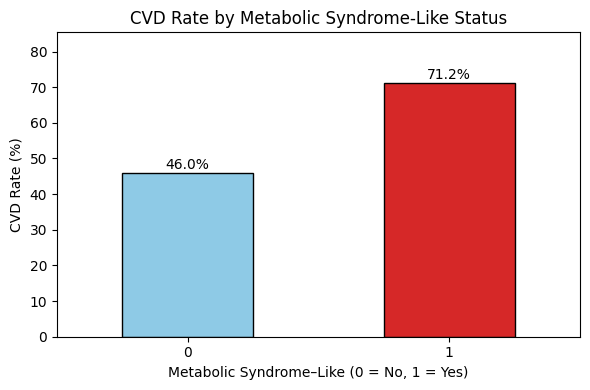

In [67]:
# Plot
plt.figure(figsize=(6,4))

cvd_rate_by_metabolic.plot(
    kind="bar",
    color=["#8ecae6", "#d62828"],
    edgecolor="black"
)

plt.title("CVD Rate by Metabolic Syndrome-Like Status")
plt.xlabel("Metabolic Syndrome–Like (0 = No, 1 = Yes)")
plt.ylabel("CVD Rate (%)")

plt.xticks(rotation=0)
plt.ylim(0, cvd_rate_by_metabolic.max() * 1.2)

# Add labels on top of bars
for i, rate in enumerate(cvd_rate_by_metabolic):
    plt.text(i, rate + 1, f"{rate:.1f}%", ha="center")

plt.tight_layout()
plt.show()


#### Interpretation

- People with three or more metabolic risk factors have a much higher CVD rate (71.2%) compared to those without this condition (46%).

- This represents roughly a 1.5× increase in risk.

Overall: The clustering of metabolic abnormalities (high BMI, glucose, cholesterol, and BP) is strongly associated with higher cardiovascular disease prevalence.

### 7.2 Pulse Pressure

Pulse pressure (ap_hi- ap_lo) serves as a simple measure of arterial stiffness and cardiovascular risk. It represents the force that the heart generates each time it contracts.

In [68]:
df_clean["pulse_pressure"] = df_clean["ap_hi"] - df_clean["ap_lo"]
df_clean = df_clean[df_clean["pulse_pressure"].between(10, 120)]

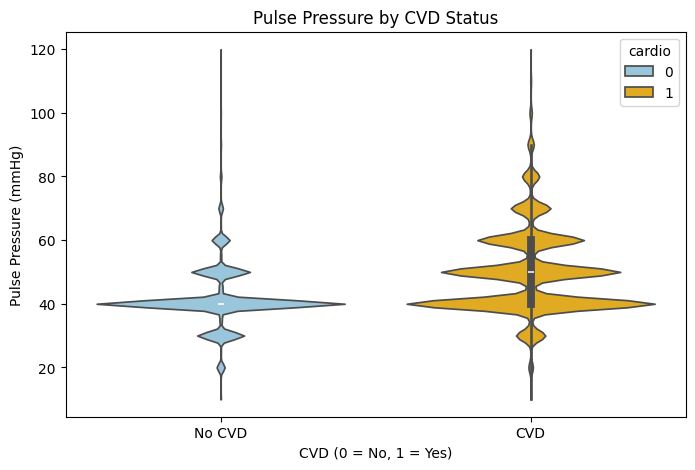

In [69]:
plt.figure(figsize=(8,5))
sns.violinplot(
    data=df_clean,
    x="cardio",
    y="pulse_pressure",
    hue="cardio", 
    palette=["#8ecae6", "#ffb703"],
    cut=0,
    inner="box"
)
plt.title("Pulse Pressure by CVD Status")
plt.xlabel("CVD (0 = No, 1 = Yes)")
plt.ylabel("Pulse Pressure (mmHg)")
plt.xticks([0,1], ["No CVD", "CVD"])
plt.show()


#### Interpretation

- Individuals with CVD have higher and more variable pulse pressure, while the non-CVD group is tightly centered around ~40 mmHg.

Overall: This supports the idea that pulse pressure is a meaningful indicator and a useful predictor of cardiovascular risk in this dataset.

# 8. Models

In this part of the project, I compared three models for predicting cardiovascular disease: 
- Logistic regression 
- Random forest 
- Gradient boosted tree

Data Setups
**Setup**    | **Features Included**                                                |
| ------------ | -------------------------------------------------------------------- |
| **Baseline** | Numeric features only                                                |
| **One-hot**  | Numeric + one-hot encoded categorical features                       |
| **Final**    | Numeric + one-hot encoded categorical + clinical engineered features |


In [70]:
# Logistic regression
log_reg = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(
        max_iter=1000,
        class_weight="balanced",  
        solver="saga",
        random_state=42 
    ))
])

In [71]:
# Random forest
rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    min_samples_leaf=20,  
    n_jobs=-1,
    random_state=42
)

In [72]:
# Gradient Boosted Tree
gb = GradientBoostingClassifier(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=5,
    random_state=42 
)

### 8.1 Baseline Model Training


Here I run models only with numerical values without any feature engineering.

In [110]:
naive_cols = config.NUM_VARS + ["alco", "smoke", "active"]
if 'bmi' in naive_cols:
    naive_cols.remove('bmi')
baseline_models = {}
for model_name, model in {"Logistic Regression": log_reg, "Random Forest": rf, "Gradient Boosted Tree": gb}.items():
    print('----------------')
    print(model_name)
    print('----------------')
    baseline_models[model_name] = train_binary_classifier(model=model, df=df_clean[naive_cols + ['cardio']], target="cardio")

----------------
Logistic Regression
----------------
=== Classification Report ===
              precision    recall  f1-score   support

           0      0.704     0.778     0.739      6948
           1      0.752     0.672     0.710      6944

    accuracy                          0.725     13892
   macro avg      0.728     0.725     0.725     13892
weighted avg      0.728     0.725     0.725     13892

=== Metrics ===
{'accuracy': 0.7254534984163548, 'precision': 0.7520940721649485, 'recall': 0.6723790322580645, 'f1': 0.7100060827250608, 'auc': 0.7844606510775238, 'confusion_matrix': [[5409, 1539], [2275, 4669]]}
----------------
Random Forest
----------------
=== Classification Report ===
              precision    recall  f1-score   support

           0      0.713     0.766     0.739      6948
           1      0.747     0.692     0.719      6944

    accuracy                          0.729     13892
   macro avg      0.730     0.729     0.729     13892
weighted avg      0.730 

Baseline Model Performance Summary
| Model                     | Accuracy | Precision | Recall | F1-score | AUC   |
| ------------------------- | -------- | --------- | ------ | -------- | ----- |
| **Logistic Regression**   | 0.725    | 0.753     | 0.670  | 0.709    | 0.7844 |
| **Random Forest**         | 0.729    | 0.752     | 0.683  | 0.716    | 0.7923 |
| **Gradient Boosted Tree** | 0.729    | 0.749     | 0.689  | 0.718    | 0.7930 |


**Best overall model (baseline stage)**:

Best overall: Gradient Boosted Tree

- Highest AUC (0.792) → best at ranking CVD vs non-CVD.

- Highest F1-score (0.718) and recall (0.689) → detects more true CVD cases.

Second best: Random Forest

- Very similar accuracy to GBT.

- Slightly lower AUC and recall, but still strong performance.

Weakest baseline : Logistic Regression

- Lower recall (0.67), so it misses more positive CVD cases.

- AUC = 0.784, acceptable for baseline.

- Useful as a simple, interpretable linear model.

Overall, Gradient Boosted Tree offered the best balance across metrics and showed the strongest ability to distinguish CVD from non-CVD cases.

### 8.2 Feature Model Training

In [75]:
# convert gender 1(Female)-> 0(Female) and 2(Male)-> 1(Male)
df_clean["gender_bin"] = (df_clean["gender"] == 2).astype(int)

#### 8.2.1 One-hot encoding

In this part of the project, I use one-hot encoding to transform all categorical variables into a numerical format that machine-learning models can work with.

Several features in the dataset — for example BMI category (bmi_bin), blood-pressure category (bp_category), cholesterol level, and glucose level — are categorical and cannot be directly understood by the algorithms.

With one-hot encoding, I create binary indicator columns for each category. This avoids creating any artificial ordering between the groups and helps the model learn from these features in a more accurate way.

In [76]:
df_encoded =df_clean.copy()

In [77]:
df_encoded = pd.get_dummies(
    df_encoded,
    columns=config.CAT_VARS,
    drop_first=False
)

In [78]:
cols_to_remove = [
    col for col in df_encoded.columns if "label" in col
] + ["bmi","age_bin", "bp_stage_num","gender","pulse_pressure","metabolic_syndrome_like","smoke","alco","active"]
df_encoded = df_encoded.drop(columns=cols_to_remove, errors="ignore")

In [90]:
df_encoded.columns

Index(['age', 'height', 'weight', 'ap_hi', 'ap_lo', 'cardio', 'age_years',
       'gender_bin', 'bp_category_Normal', 'bp_category_Elevated',
       'bp_category_Hypertension Stage 1', 'bp_category_Hypertension Stage 2',
       'bp_category_Hypertensive Crisis', 'bmi_bin_Underweight',
       'bmi_bin_Normal', 'bmi_bin_Overweight', 'bmi_bin_Obesity I',
       'bmi_bin_Obesity II', 'bmi_bin_Obesity III', 'cholesterol_1',
       'cholesterol_2', 'cholesterol_3', 'gluc_1', 'gluc_2', 'gluc_3'],
      dtype='object')

In [92]:
feature_cols = [c for c in df_encoded.columns if c != "cardio"]
encoded_models = {}
for model_name, model in {"Logistic Regression": log_reg, "Random Forest": rf, "Gradient Boosted Tree": gb}.items():
    print('----------------')
    print(model_name)
    print('----------------')
    encoded_models[model_name] = train_binary_classifier(model=model, df=df_encoded[feature_cols + ['cardio']], target="cardio")

----------------
Logistic Regression
----------------
=== Classification Report ===
              precision    recall  f1-score   support

           0      0.699     0.805     0.748      6948
           1      0.770     0.653     0.706      6944

    accuracy                          0.729     13892
   macro avg      0.734     0.729     0.727     13892
weighted avg      0.734     0.729     0.727     13892

=== Metrics ===
{'accuracy': 0.7286927728188886, 'precision': 0.7695703854644252, 'recall': 0.6526497695852534, 'f1': 0.7063040598457103, 'auc': 0.7936666081344232, 'confusion_matrix': [[5591, 1357], [2412, 4532]]}
----------------
Random Forest
----------------
=== Classification Report ===
              precision    recall  f1-score   support

           0      0.716     0.784     0.749      6948
           1      0.761     0.689     0.723      6944

    accuracy                          0.737     13892
   macro avg      0.739     0.737     0.736     13892
weighted avg      0.739 



Model Performance Summary
| Model                 | Accuracy | Precision | Recall | F1-score | AUC    |
| --------------------- | -------- | --------- | ------ | -------- | ------ |
| Logistic Regression   | 0.729    | 0.770     | 0.653  | 0.706    | 0.7937 |
| Random Forest         | 0.737    | 0.761     | 0.689  | 0.723    | 0.8006 |
| Gradient Boosted Tree | 0.735    | 0.763     | 0.681  | 0.720    | 0.8023 |


Best overall: Gradient Boosted Tree (slightly highest accuracy & AUC).

Logistic regression is a bit worse but still decent -> nice as a baseline.

Tree models (Random Forest and Gradient Boosted Tree) give you a small but consistent improvement in F1 and AUC, so they’re better at ranking CVD risk.
Overall, the Gradient Boosted Tree was the best overall baseline model showing the highest AUC.


#### 8.2.2 Final model

In this part of the project I combined all numeric + categorical + clinical features in order to run the models.

In [87]:
df_final_model = df_encoded.copy()

In [88]:
# add pulse pressure and metabolic_syndrome_like columns to a final dataset
df_final_model["pulse_pressure"] = df_clean["pulse_pressure"].values
df_final_model["metabolic_syndrome_like"] = df_clean["metabolic_syndrome_like"].values

feature_cols3 = [c for c in df_final_model.columns if c != "cardio"]

In [94]:
feature_cols3

['age',
 'height',
 'weight',
 'ap_hi',
 'ap_lo',
 'smoke',
 'alco',
 'active',
 'age_years',
 'bmi',
 'gender_bin',
 'bp_category_Normal',
 'bp_category_Elevated',
 'bp_category_Hypertension Stage 1',
 'bp_category_Hypertension Stage 2',
 'bp_category_Hypertensive Crisis',
 'bmi_bin_Underweight',
 'bmi_bin_Normal',
 'bmi_bin_Overweight',
 'bmi_bin_Obesity I',
 'bmi_bin_Obesity II',
 'bmi_bin_Obesity III',
 'cholesterol_1',
 'cholesterol_2',
 'cholesterol_3',
 'gluc_1',
 'gluc_2',
 'gluc_3',
 'pulse_pressure',
 'metabolic_syndrome_like']

In [89]:
final_models = {}
for model_name, model in {"Logistic Regression": log_reg, "Random Forest": rf, "Gradient Boosted Tree": gb}.items():
    print('----------------')
    print(model_name)
    print('----------------')
    final_models[model_name] = train_binary_classifier(model=model, df=df_final_model[feature_cols3 + ['cardio']], target="cardio")

----------------
Logistic Regression
----------------
=== Classification Report ===
              precision    recall  f1-score   support

           0      0.700     0.804     0.748      6948
           1      0.770     0.655     0.708      6944

    accuracy                          0.729     13892
   macro avg      0.735     0.729     0.728     13892
weighted avg      0.735     0.729     0.728     13892

=== Metrics ===
{'accuracy': 0.7294845954506191, 'precision': 0.7697257026752455, 'recall': 0.6546658986175116, 'f1': 0.7075486381322957, 'auc': 0.793719523438101, 'confusion_matrix': [[5588, 1360], [2398, 4546]]}
----------------
Random Forest
----------------
=== Classification Report ===
              precision    recall  f1-score   support

           0      0.713     0.789     0.749      6948
           1      0.764     0.683     0.721      6944

    accuracy                          0.736     13892
   macro avg      0.739     0.736     0.735     13892
weighted avg      0.739  

Model Performance Summary
| Model                 | Accuracy | Precision | Recall | F1    | AUC    |
| --------------------- | -------- | --------- | ------ | ----- | ------ |
| Logistic Regression   | 0.729    | 0.770     | 0.655  | 0.708 | 0.7937 |
| Random Forest         | 0.736    | 0.764     | 0.683  | 0.721 | 0.8005 |
| Gradient Boosted Tree | 0.737    | 0.764     | 0.684  | 0.722 | 0.8022 |




- The tree-based models perform slightly better than logistic regression, with Gradient Boosted Trees achieving the best overall scores.

- Random Forest and GBT show higher AUC values indicating better ability to detect CVD risk compared to the linear model.

### 8.3  Summary tables

Data Setups
| **Setup**    | **Features Included**                                                |
| ------------ | -------------------------------------------------------------------- |
| **Baseline** | Numeric features only                                                |
| **One-hot**  | Numeric + one-hot encoded categorical features                       |
| **Final**    | Numeric + one-hot encoded categorical + clinical engineered features |


Combined Model Performance Table

| Setup        | Model                 | Accuracy  | Precision | Recall    | F1-score  | AUC        |
| ------------ | --------------------- | --------- | --------- | --------- | --------- | ---------- |
| **Baseline** | Logistic Regression   | 0.725     | 0.753     | 0.670     | 0.709     | 0.7844     |
| **Baseline** | Random Forest         | 0.729     | 0.752     | 0.683     | 0.716     | 0.7923     |
| **Baseline** | Gradient Boosted Tree | 0.729     | 0.749     | --**0.689**-- | **0.718** | 0.7930     |
| **One-hot**  | Logistic Regression   | 0.729     | 0.770     | 0.653     | 0.706     | 0.7937     |
| **One-hot**  | Random Forest         | --**0.737**-- | 0.761     | --**0.689**-- | --**0.723**-- | 0.8006     |
| **One-hot**  | Gradient Boosted Tree | 0.735     | 0.763 | 0.681     | 0.720     | --**0.8023**-- |
| **Final**    | Logistic Regression   | 0.729     | 0.770     | 0.655     | 0.708     | 0.7937     |
| **Final**    | Random Forest         | 0.736 | 0.764     | 0.683 | 0.721 | 0.8005     |
| **Final**    | Gradient Boosted Tree | 0.735     | --**0.764**-- | 0.684     | 0.722     | 0.8022 |





#### Interpretation
Across all experiments, tree-based models consistently outperformed Logistic Regression.

Top-performing models
1. One-hot Random Forest
- Highest accuracy: 0.737
- Highest F1-score: 0.723
- Highest recall: 0.689

This model is the best option if we prioritize recall, which is important in a medical setting because missing a positive CVD case can have serious consequences.

2. One-hot Gradient Boosted Tree
- Highest AUC: 0.8023
- Accuracy and F1-score slightly below Random Forest
- Best ability to separate CVD vs. non-CVD across all thresholds

This model is the best option if the primary evaluation metric is AUC, since it provides the strongest overall discrimination performance.



Both models performed very well, but the preferred model depends on the objective:

- If the priority is recall (detecting as many true CVD cases as possible): One-hot Random Forest.

- If the priority is AUC (overall ranking quality and discrimination ability): One-hot Gradient Boosted Tree.

In a medical context, both recall and AUC are important.
Therefore, these two models represent the strongest solutions, each optimal for slightly different goals

# 9. Conclusion & Future steps



**Key findings:**

- CVD risk increased with age, higher BMI, and elevated blood pressure.

- Strongest patterns were seen in metabolic syndrome and pulse pressure.

- Gradient Boosted Tree was the best model (AUC ≈ 0.8023) together with final or one-hot feature set.


**Future steps**

- Error analysis: Look closely at false positives and false negatives to understand which patient groups the model struggles with.

- Feature improvement: Add more clinical features

- Model tuning: Perform tuning and try stronger models like XGBoost




